# Importing all the conversations

This is a bit trickier as you need to do something with all the conversations you're loading up.

---

Load up a tonne of libraries

In [1]:
import datetime
import json
import os
import pickle
import random
import re
import textwrap
from pathlib import Path
from collections import OrderedDict

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.spatial import ConvexHull

import message_helpers as mh
from hangouts_loader import load_hangouts


In [2]:
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["font.sans-serif"] = ["Segoe UI Emoji"]


In [3]:
pickle_name = "all_convo.pickle"
pickle_path = Path(pickle_name)


Set your name here. This is so that you can take yourself out of some of the graphs. Because these are conversations, naievely, they go A B A B and so on, so you'll be roughly 50% of the messages, which makes other trends hard to see.

In [4]:
MY_NAME = "Ben Doherty"


In [5]:
def parse_obj(obj):
    """Unfuck facebook's message storage encoding.

    Facebook stores their messages in some kind of insane mix of latin 1 and utf-8
    This means that emoji and iOS punctuation are broken unless decoded with this.

    Args:
        obj (dict): a part of a facebook message

    Returns:
        dict: tht object, but not munted
    """
    for key in obj:
        if isinstance(obj[key], str):
            obj[key] = obj[key].encode("latin_1").decode("utf-8")
        elif isinstance(obj[key], list):
            obj[key] = list(
                map(
                    lambda x: x
                    if type(x) != str
                    else x.encode("latin_1").decode("utf-8"),
                    obj[key],
                )
            )
        pass
    return obj


def sumarise_convo(name, data, verbose=False):
    words = {}
    words[name] = data.content.str.cat(sep=" ")
    wordcount = len(words[name].split(" "))

    unique_words = set(words[name].split(" "))

    pool = " ".join([str(x) for x in data.content.to_list()]).lower()
    clean = re.sub(mh.PUNCTUATION_REGEX, " ", pool, flags=re.VERBOSE)
    # and replace it with a single space
    stopped = list(set([w for w in clean.split() if w not in mh.STOP_WORDS]))

    if verbose:
        print(
            f"{name} wrote {wordcount} words ({len(words[name])} characters)"
            f" and used {len(stopped)} different words."
        )
    return {
        "participant": name,
        "wordcount": wordcount,
        "unique_words": len(unique_words),
        "cleaned_unique": len(stopped),
    }


def get_message_length(message):
    if type(message) is str:
        return len(message)
    else:
        return len(str(message))


def replace_typographic_apostrophy(message):
    if type(message) is str:
        return message.replace("’", "'")
    else:
        return message


def load_whole_inbox(rootdir, platform="Facebook", verbose=False):
    conversations = []
    for d in os.listdir(rootdir):
        conversations.append(d)
    print(
        f"There are {len(conversations)} conversations to look at from {platform}. ({rootdir})"
    )
    # conversations

    convo_df_list = []

    for convo in os.listdir(rootdir):
        for f in os.listdir(os.path.join(rootdir, convo)):
            try:
                message_list = []
                path = os.path.join(os.path.join(rootdir, convo, f))
                if Path(path).is_file():
                    with open(path, "r") as fb_data:
                        messages = json.load(fb_data, object_hook=parse_obj)
                        message_list.extend(messages["messages"])

                if len(message_list) != 0:
                    df = pd.DataFrame(message_list)
                    df["source_convo"] = convo
                    df["datetime"] = df.timestamp_ms.apply(
                        lambda x: datetime.datetime.fromtimestamp(x / 1000.0)
                    )

                    if "content" in df.columns:
                        df["message_length"] = df.content.apply(get_message_length)
                        df.content = df.content.apply(replace_typographic_apostrophy)
                    else:
                        df["message_length"] = 0
                        df["content"] = np.nan

                    df["platform"] = platform

                    convo_df_list.append(df)
                    if verbose:
                        try:
                            print(convo, f)
                            print(f"{df.shape[0]} rows, between:", ", ".join(list(df.sender_name.unique())))
                            print()
                        except:
                            pass

            except Exception as e:
                print("exception", convo, e)
    print(f"finished with {platform}")
    return convo_df_list


In [6]:
fb_rootdir = "fb_data/messages/inbox"
ig_rootdir = "ig_data/inbox"

print("Loading from source files")
fb_convo_df_list = load_whole_inbox(fb_rootdir, platform="Facebook")
fb_convo_df_list_2 = load_whole_inbox(fb_rootdir + "_1", platform="Facebook")
fb_archived_threads = load_whole_inbox("fb_data/messages/archived_threads", platform="Facebook", verbose=False)
ig_convo_df_list = load_whole_inbox(ig_rootdir, platform="Instagram")
ho_convo_df_list = [load_hangouts()]

convo_df_list = (
    fb_convo_df_list + fb_convo_df_list_2 + ig_convo_df_list + ho_convo_df_list
)
# print(len(convo_df_list))
all_convo_df = pd.concat(convo_df_list)
print(f"All_convo_df has {all_convo_df.shape[0]} rows")
all_convo_df.drop_duplicates(subset=["sender_name", "timestamp_ms"],inplace=True)
print(f"deduped: all_convo_df has {all_convo_df.shape[0]} rows")
print("Done")


Loading from source files
There are 1214 conversations to look at from Facebook. (fb_data/messages/inbox)
finished with Facebook
There are 43 conversations to look at from Facebook. (fb_data/messages/inbox_1)
finished with Facebook
There are 6 conversations to look at from Facebook. (fb_data/messages/archived_threads)
finished with Facebook
There are 144 conversations to look at from Instagram. (ig_data/inbox)
finished with Instagram
All_convo_df has 1010751 rows
deduped: all_convo_df has 991967 rows
Done


In [7]:
print(
    f"Overall, there are {len(all_convo_df)}, messages in this dataset. "
    f"These come from about {len(all_convo_df.sender_name.unique())} people, "
    f"covering a period of {str(all_convo_df.datetime.max()-all_convo_df.datetime.min()).split(' days')[0]} days "
    f"between {all_convo_df.datetime.min():%B, %Y} and {all_convo_df.datetime.max():%B, %Y}. "
    f"Over {len(all_convo_df.platform.unique())} platforms:"
)
all_convo_df.platform.value_counts()


Overall, there are 991967, messages in this dataset. These come from about 778 people, covering a period of 5472 days between January, 2007 and December, 2021. Over 3 platforms:


Facebook     764999
Hangouts     146211
Instagram     80757
Name: platform, dtype: int64

## Merge names

Some people have different names across different platforms, firstly let's get a list of unique names, and then define a dictionary that will say what to merge into what.

In [8]:
names = []
platform_names = {}
for platform, df in all_convo_df.groupby("platform"):
    vc = df.sender_name.value_counts()
    these_names = vc[vc > 100].index.to_list()
    names += these_names
    print("\n",platform, "\n",these_names)
    platform_names[platform] = set(these_names)
# print(platform_names)


 Facebook 
 ['Ben Doherty', 'Meike Wijers', 'Ivana Kuzmanovska', 'Jenn Martin', 'Lucy Rimmer', 'Bree-Danielle Wyatt', 'Irina Belova', 'Karin Frost', 'Maddie Johanson', 'Natalie Barnes', 'Annisa Rivera Rizal', 'Katherine Withnell', 'Erika Bloomingdale', 'Elizabeth Deacon', 'Jülz Milthorpe', 'Sarah Maloof', 'Nazmul Azim Khan', 'Emma Stewart', 'Thearlaich Ogilive', 'Byron Sullivan', 'Antonia Sheil', 'Alessandra Moschella', 'Ishaan Varshney', 'Jodie Hinton', 'Tiara Dobbs', '', 'Shelda Kristie', 'Ali Jane', 'Adam Pigott', 'Marc Micuta', 'Debbie Hodge', 'Jess Howard', 'Brndn Wlsh', 'Rachel Bee', 'Bethan Ellis-Jones', 'Sebastian Winnett', 'Baptiste Higgs', 'Alexander Lee', 'Shawnee Finlayson', 'MattWho Bell', 'Barnaby Bennett', 'Elynda Ma', 'Heather Louise', 'Aiden Ray', 'Lydia Durkin George', 'Barry Dineen', 'Kelly Melrose', 'Y-e Ho', 'Yien Yien Soo', 'Lauren Maree', 'Clare Jackson', 'John Richard Gale', 'Bianca Toth', 'Anthea Murray', 'Deezy Jefferson', 'Other User', 'Laurel Fox', 'Sophie 

In [9]:
fb_s = set(platform_names["Facebook"])
ig_s = set(platform_names["Instagram"])
ho_s = set(platform_names["Hangouts"])
# print(fb_s.symmetric_difference(ig_s))
# print(fb_s.intersection(ig_s))
print("\nshows in all platforms", fb_s & ig_s & ho_s)
print("\nshows in fb and ig", fb_s & ig_s)
print("\nfb only", fb_s - ig_s)
print("\nig only", ig_s - fb_s)



shows in all platforms {'Lucy Rimmer', 'Alessandra Moschella', 'Ben Doherty', 'Irina Belova'}

shows in fb and ig {'Maddie Johanson', 'Irina Belova', 'Bree-Danielle Wyatt', 'Brooke Jackson', 'Ben Doherty', 'Meike Wijers', 'Jenn Martin', 'Alessandra Moschella', 'Lucy Rimmer', 'Katherine Withnell', 'Natalie Barnes', 'Shelda Kristie'}

fb only {'', 'Barry Dineen', 'Chris Bickerton', 'PayPal', 'Nicole Sarapata', 'Shanny Lam', 'Brown Guy', 'Jess Howard', 'Leslie Berman', 'Tina G Lee', 'Shirin Borthwick', 'Brndn Wlsh', 'Polly Brown', 'Melanie Mury', 'Elynda Ma', 'Josh Mason', 'Lydia Durkin George', 'Toby Shew', 'Joseph Samuel', 'Katharine Eva', 'Adele Varcoe', 'Hannah Elphick', 'Baptiste Higgs', 'Nick Flutter', 'Rachel Elizabeth Smith', 'Anna Biddlestone', 'Tiara Dobbs', 'Sarah Maloof', 'Sophie Chisholm', 'Debbie Hodge', 'Facebook for Business', 'Jared Na', 'Kirby Rees', 'Kirsty Pat Douglas', 'Thearlaich Ogilive', 'Ellesha Dobbs', 'Mikey Slezak', 'Byron Sullivan', 'Maryam Alavi', 'Danielle 


Use the lists above to work out who shows up in more than one list, but under different names, and then use the thesaurus below to map their names to a single value.

In [10]:
def fold_names(input_name):
    annisa = "Annisa Rivera Rizal"
    byron = "Byron Sullivan"
    charlie = "Charles Ogilvie"
    clarrie = "Clarrie Morabito"
    ivana = "Ivana Kuzmanovska"
    jess = "Jess Howard"
    jodie = "Jodie Hinton"
    julz = "Jülz Milthorpe"
    karin = "Karin Ke"
    tones = "Antonia Sheil"
    brendan = "Brendan Walsh"
    thesaurus = {
        "Byron Sullivan": byron,
        "Byron": byron,
        "Brndn Wlsh": brendan,
        "Thearlaich Ogilive": charlie,
        "Charles OGILVIE": charlie,
        "Charles Ogilvie": charlie,
        "Karin Frost": karin,
        "karin ke": karin,
        "Ivana Kuzmanovska": ivana,
        "ivana kuzmanovska": ivana,
        "Jülz": julz,
        "Jülz Milthorpe": julz,
        "jesshoward": jess,
        "Jess Howard": jess,
        "Jodie": jodie,
        "Tones": tones,
        "annisarivera": annisa,
        "Clarrie": clarrie,
        "tanyaruby": "Tanya P",
        "iflaneuse": "Nicole Gardiner",
        "Frank": "Francis Lockie",
    }
    new_name = thesaurus.get(input_name, input_name)
    # if new_name != input_name:
    #     print(f"renamed {input_name} to {new_name}")
    return new_name


all_convo_df["input_names"] = all_convo_df.sender_name
all_convo_df.sender_name = all_convo_df.sender_name.apply(fold_names)


<AxesSubplot:>

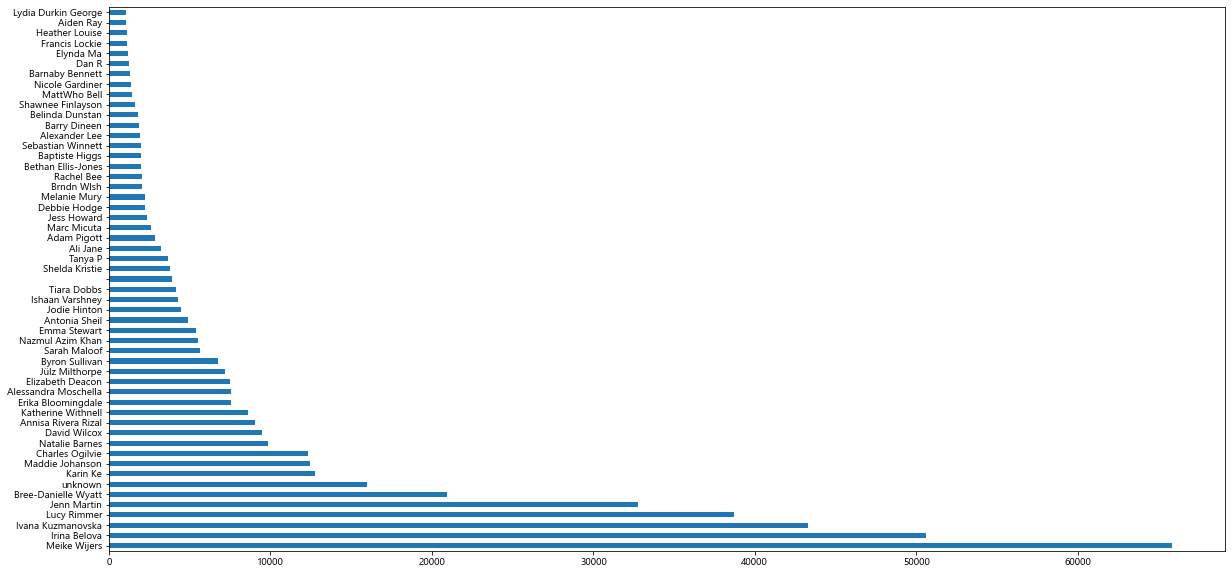

In [11]:
vc = all_convo_df.sender_name.value_counts()
vc[(vc>1000) & (vc<100000)].plot(kind="barh")

## Initials

To label a lot of graphs we'll need a compact way to represent people, so I (Ben Doherty) can be shown as BD.

In [12]:
all_initials = all_convo_df.sender_name.value_counts().to_dict()
initials_pool = []
for name in all_initials.keys():
    split = [x for x in re.split("[ \.-]", name) if x != ""]
    try:
        initials = "".join([n[0] for n in split]).upper()
        if initials in initials_pool:
            # print("uh oh, double up on", initials, name, initials_pool)
            initials = "".join([n[0] for n in split]).upper() + name.split()[-1][1]
            # print("replaced with", initials)
            if initials in initials_pool:
                initials = (
                    split[0].upper()
                    + split[1].lower()
                    + split[-1].upper()
                    + split[-2].lower()
                )
                if initials in initials_pool:
                    print("fuck, complicated", name)
                    initials = name+"x"
    except Exception as e:
        # print(name, e, split)
        initials = name+"x"
    all_initials[name] = initials
    initials_pool.append(initials)

all_convo_df["initials"] = all_convo_df.sender_name.apply(lambda x: all_initials[x])
all_convo_df[["sender_name", "content", "initials"]].drop_duplicates(subset="initials").sample(10)


,sender_name,content,initials
0,Elena Bonanni,󾌸󾌸,EBo
1,Siân Evans,"Sorry, i didnt mean to make you disapear. my i...",SEv
2,Joey Rumbold,Hi Ben \nI can pick up early this evening if t...,JRu
0,Ro M Rodriguez,󾮗🏻,RMR
1078,Dan R,"its actually quite linear going by that graph,...",DR
0,Chris Grant,Thanks - I have client meetings with my boss o...,CHRISgrantGRANTchris
0,Sarah Brown,i did read that on the final page. the graph ...,SBr
27,Mitch Reed,Yes from me - thank you!,MITCHreedREEDmitch
0,Ghislaine Halpenny,Thanks. Much appreciated.,GH
1,Elizabeth Illsley,Cheers muchly!\n\nI certainly will when i'm in...,EI


## Gender

I've had to make a new table, and just make up what people are assigning, but I think it's basically right. This will show if I'm biased in one way or the other in my messaging.

I've put myself in with a gender of `me` so that I can tell where the split really lies, as I'm &thickapprox; 50% of the messages.

In [16]:
gender_file = "gender.csv"
gender_df = pd.read_csv(gender_file)
all_convo_df = pd.merge(all_convo_df, gender_df, on="sender_name", how="left")
all_convo_df.sample(4)

,sender_name,timestamp_ms,content,type,is_unsent,users,source_convo,datetime,message_length,platform,...,ip,gifs,files,audio_files,missed,event_id,input_names,initials,gender_x,gender_y
230117,Ben Doherty,1.589421e+12,NaN,Generic,False,NaN,lucyrimmer_pfwdzikwla,2020-05-14 11:53:31.409000,3,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Ben Doherty,BD,me,me
518631,Lucy Rimmer,1.500272e+12,Oh yeAh,Generic,False,NaN,lucyrimmer_pfwdzikwla,2017-07-17 16:20:28.973000,7,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Lucy Rimmer,LR,f,f
853140,Brndn Wlsh,1.430615e+12,Yea what a legend,Generic,False,NaN,timandbrndn_tno9fbhybq,2015-05-03 11:10:26.779000,17,Facebook,...,NaN,NaN,NaN,NaN,NaN,NaN,Brndn Wlsh,BW,m,m
587901,Irina Belova,1.394232e+12,Not yet,Generic,False,NaN,NaN,2014-03-08 09:38:41.563014,7,Hangouts,...,NaN,NaN,NaN,NaN,NaN,NaN,Irina Belova,IB,f,f


In [15]:
gender_list = ["me", "f", "m"] # edit this to match your gender_file
not_assigned = all_convo_df[[x not in gender_list for x in all_convo_df.gender]]
if not_assigned.shape[0] != 0:
    print(
        f"you need to tag people in the gender file: {gender_file}\n"
        "If you don't want to, just comment this and the section above out"
    )
    not_assigned.sender_name.valuecounts()


In [15]:
all_convo_df[[x not in gender_list for x in all_convo_df.gender]].shape

(0, 25)

In [16]:
def clean_and_stop(content, as_list=False):
    try:
        clean = re.sub(
            mh.PUNCTUATION_REGEX,
            " ",
            content,
            flags=re.VERBOSE,  # and replace it with a single space
        )
        stopped = [w.lower() for w in clean.split() if w.lower() not in mh.STOP_WORDS]
        # print(content, "=>", stopped)
        if as_list:
            return stopped
        else:
            return " ".join(stopped)
    except Exception as e:
        # print(content, e)
        return content


all_convo_df["clean_content"] = all_convo_df.content.apply(clean_and_stop)


In [17]:
print(f"saving new pickle: {pickle_path}")
pd.to_pickle(all_convo_df, pickle_path)
print("done")

print(
    f"Overall, there are {len(all_convo_df)}, messages in this dataset. "
    f"These come from about {len(all_convo_df.sender_name.unique())} people, "
    f"covering a period of {str(all_convo_df.datetime.max()-all_convo_df.datetime.min()).split(' days')[0]} days "
    f"between {all_convo_df.datetime.min():%B, %Y} and {all_convo_df.datetime.max():%B, %Y}. "
    f"Over {len(all_convo_df.platform.unique())} platforms:"
)
all_convo_df.platform.value_counts()

saving new pickle: all_convo.pickle
done
Overall, there are 933925, messages in this dataset. These come from about 87 people, covering a period of 5472 days between January, 2007 and December, 2021. Over 3 platforms:


Facebook     733106
Hangouts     129683
Instagram     71136
Name: platform, dtype: int64

<AxesSubplot:>

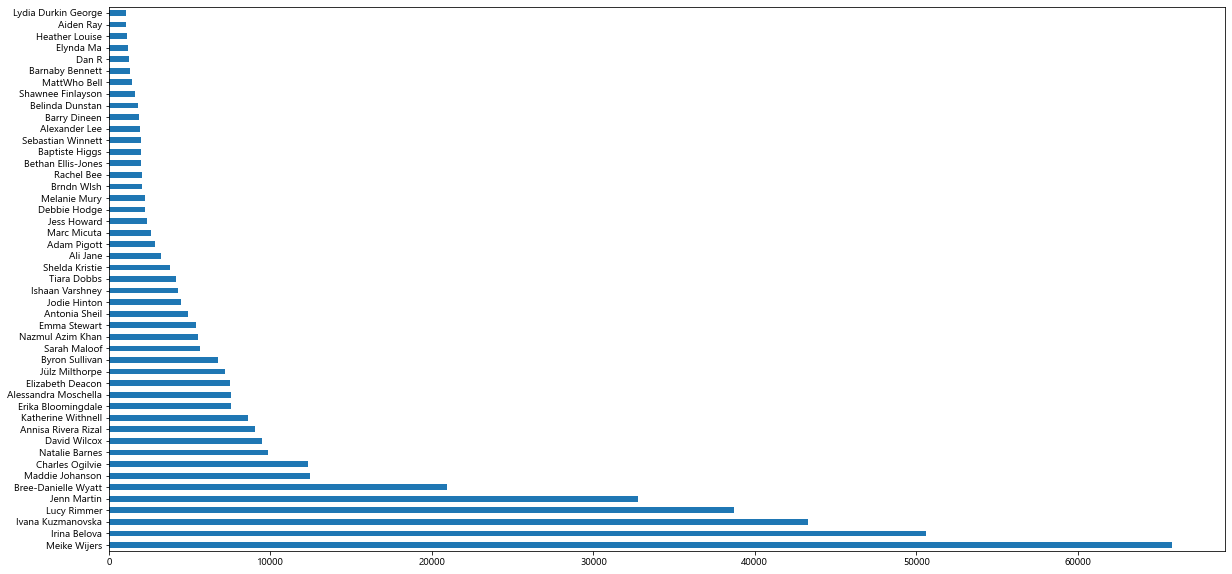